In [ ]:
#| default_exp wh_transcribe

## Precompute Whisper transcriptions for VQ bottleneck distilation

Doing transcription means sampling from the Whisper auto-regresive decoder. This is too slow to do for each training batch. Fortunately the trainscriptions are small text snippets so we can precompute them once for the whole dataset.

We use segments from Voice Activity Detection to reduce any boundary issues, the we use webdataset to yields multiple chunks from a FLAC file we only load once. The VAD segments are merged into longer chunks to make Whisper processing more efficent (it always processes 30s at a time)

**Usage:**  
```
python -m whisperspeech.wh_transcribe librilight-large-wo6454-flac-000002.tar
```

You can pass in either a URL or a local file name. Either way it will expect a `vad` file in the local directory. The result will go into a file in the current directory named after the source file but replacing `flac` with `txt`.

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
import os
import io
import time
import torch
import torchaudio

In [ ]:
#| export
from pathlib import Path
import json
from fastprogress import progress_bar, master_bar
import numpy as np
import random

import whisper

from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader

from fastcore.script import *

from whisperspeech import vad, utils
import webdataset as wds

from whisperspeech.inference import get_compute_device

In [ ]:
import pylab as plt
import IPython

In [ ]:
flac_url = 'https://huggingface.co/datasets/collabora/librilight-webdataset/resolve/main/librilight-small-flac-000000.tar'

In [ ]:
flac_url = './librilight-small-flac-000000.tar'

## Merge VAD segments into longer chunks

In [ ]:
#| exporti
# let's make it a bit more conservative
# with full 30 second chunks it sometimes misses a small part of the transcript
def random_cutter(dur):
    if random.random() < 0.5:
        return dur > 28 * (random.random()*0.95+0.05)
    else:
        return dur > 28

def chunk_merger(segments, should_cut=lambda x: x > 28):
    if len(segments) == 0: return segments
    curr_start = segments[0][0]
    curr_end = 0
    merged = []

    for ts,te in segments:
        if should_cut(te - curr_start) and curr_end - curr_start > 0:
            merged.append((curr_start, curr_end))
            curr_start = ts
        curr_end = te
    merged.append((curr_start, curr_end))
    return merged

In [ ]:
# load some VAD ouputs
ds = wds.WebDataset(
    vad.flac_to_vad_name(flac_url)
).decode().to_tuple('vad.npy')
chunks = [x[0] for x in progress_bar(ds, total='noinfer')]

In [ ]:
# quick test
len(chunks[0]), len(chunk_merger(chunks[0]))

(46, 28)

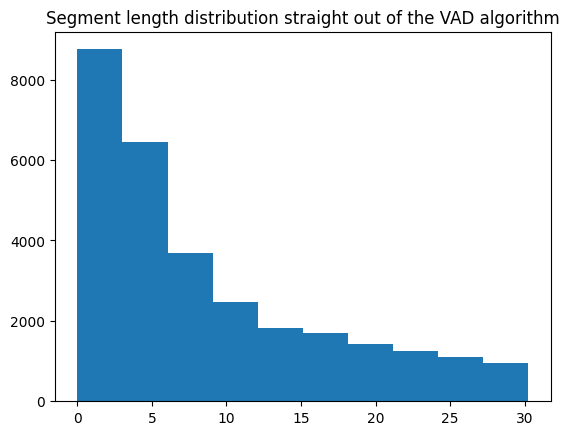

In [ ]:
plt.hist([te-ts for x in chunks for ts,te in x])
plt.title('Segment length distribution straight out of the VAD algorithm');

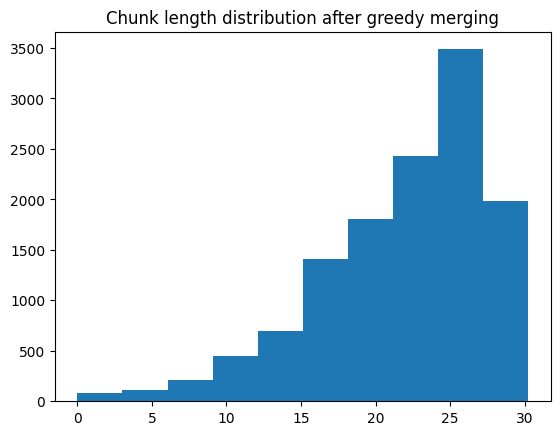

In [ ]:
plt.hist([te-ts for x in chunks for ts,te in chunk_merger(x)]);
plt.title('Chunk length distribution after greedy merging');

In [ ]:
(np.array([te-ts for x in chunks for ts,te in chunk_merger(x)]) < 10).mean()

0.03671825647504738

In the above distribution only 3,7% of the samples have < 10 seconds. We noticed that this limits the ability of the T2S model to generate short sequences reliably.

It does not seem to matter for quantizing Whisper so we can keep this distribution (it uses less compute for training).

For T2S we can add some more shorter chunks at random:

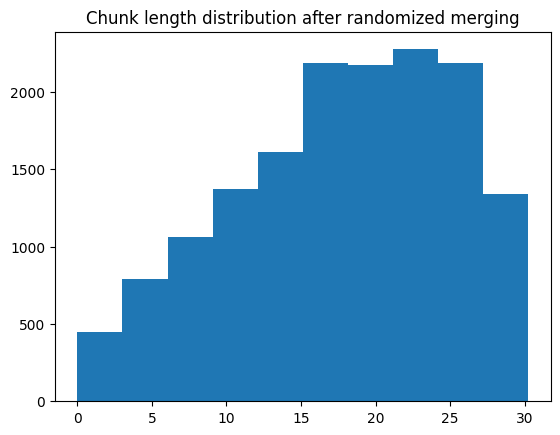

In [ ]:
plt.hist([te-ts for x in chunks for ts,te in chunk_merger(x, random_cutter)])
plt.title('Chunk length distribution after randomized merging');

## Merge the FLAC and VAD datasets

First we want to merge the VAD dataset with the FLAC audio data.

In [ ]:
#| exporti
def merge_in(*datasets):
    """Merge multiple datasets into the current one returning samples with the union of keys.
    
    It requires (and validates) all datasets to have the same ordering of keys so you have
    to use it before any sample shuffling. Shard shuffling is ok.
    """
    def merge_loop(main_samples):
        for samples in zip(*[main_samples]+[iter(x) for x in datasets]):
            key = samples[0]['__key__']
            news = {}
            for s in samples:
                assert s['__key__'] == key
                news.update(s)
            yield news
    return merge_loop

In [ ]:
#| exporti
import copy

In [ ]:
#| exporti
# a workaround for https://github.com/webdataset/webdataset/issues/297
# should be possible to use ds.compose here
def wds_compose(ds, *args):
    ds = copy.copy(ds)
    ds.pipeline = copy.copy(ds.pipeline)
    for f in args:
        ds.append(f)
    return ds

In [ ]:
ds = wds_compose(vad.load_dataset(flac_url),
    merge_in(wds.WebDataset(vad.flac_to_vad_name(flac_url)).decode())
)

In [ ]:
for s in ds: break
s # notice the 'vad.npy' values that was missing from the FLAC dataset

{'__key__': 'small/100/sea_fairies_0812_librivox_64kb_mp3/01_baum_sea_fairies_64kb',
 '__url__': 'librilight-small-vad-000000.tar.gz',
 'flac': (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), 16000),
 'json': {'speaker': '100',
  'book_meta': {'id': '2315',
   'title': 'Sea Fairies',
   'description': "<p>In 1910, Baum hoped to end the Oz series and follow with a new series about a little girl named Trot and her sailor companion, Cap'n Bill. The Sea Fairies (1911) was the first book in the projected series and took Trot and Cap'n Bill under the sea where they had adventures with mermaids and other fantastic creatures. It was followed by Sky Island (1912) and then Baum returned to the Oz titles. He brought Trot and Cap'n Bill to Oz in the Scarecrow of Oz (1915). (Summary by Judy Bieber)</p>",
   'url_text_source': 'http://www.gutenberg.org/etext/4358',
   'language': 'English',
   'copyright_year': '1911',
   'num_sections': '22',
   'url_rss': 'https://librivox.org/rss/2315',
   'url_zip_fi

## Split the audio into chunks

After we merge the datasets and chunk the segments we can split each audio file into individual samples and pad them to 30s.

In [ ]:
#| exporti
def split_to_chunks(stream, ikey='vad.npy', pad_to_seconds=30, random_shift=False):
    for s in stream:
        audio, sr = s['audio']
        imax = len(s[ikey]) - 1
        for i,(ts,te) in enumerate(s[ikey]):
            samples = audio[0,int(ts*sr):int(te*sr)]
            if pad_to_seconds is not None:
                padding = pad_to_seconds*sr-samples.shape[-1]
                lpad = random.randint(0, padding) if random_shift else 0
                samples = F.pad(samples, (lpad, padding-lpad))
            yield {"__key__": s['__key__'] + f"_{i:03d}",
                   "__url__": s['__url__'],
                   "i": i, "imax": imax,
                   "tstart": ts, "tend": te, "total_seconds": audio.shape[-1]/sr,
                   "lpad": lpad, "rpad": padding-lpad,
                   "lpad_s": lpad/sr, "rpad_s": (padding-lpad)/sr,
                   "samples": samples, "sample_rate": sr}

In [ ]:
split_ds = wds_compose(ds,
   wds.map_dict(**{"vad.npy":chunk_merger}),
   split_to_chunks,
   utils.resampler(16000, 'samples_16k')
)

In [ ]:
for s in split_ds: break
s

{'__key__': './dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_000',
 '__url__': '../wolnelektury-preproc-wds/wolnelektury-vad-000001.tar.gz',
 'i': 0,
 'imax': 115,
 'tstart': 0.00844,
 'tend': 10.06,
 'total_seconds': 2776.057029478458,
 'lpad': 0,
 'rpad': 879616,
 'lpad_s': 0.0,
 'rpad_s': 19.9459410430839,
 'samples': tensor([ 1.8147e-05, -4.9754e-06, -1.3190e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]),
 'sample_rate': 44100,
 'samples_16k': tensor([ 4.3992e-06,  9.4182e-07, -1.3307e-06,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00])}

In [ ]:
IPython.display.display(IPython.display.Audio(s['samples_16k'], rate=16000))

## Transcribe

In [ ]:
whmodel = whisper.load_model('base.en')
decoding_options = whisper.DecodingOptions(language='en')

In [ ]:
output = flac_url.rsplit("/", 1)[1].replace('flac', 'txt') + ".gz"
with wds.TarWriter(output) as sink:
    for s in progress_bar(split_ds, total=256):
        mel = whisper.log_mel_spectrogram(s['samples'].unsqueeze(0).cuda())
        embs = whmodel.encoder(mel)
        decs = whmodel.decode(embs, decoding_options)

        sink.write({
            "__key__": s['__key__'],
            "txt": decs[0].text,
        })

## Transcribe in batches

We have one more thing to add – batch processing makes the transcription quite a bit faster (bs=16 brings a 4.5x speedup).

In [ ]:
batched_ds = wds_compose(split_ds,
    wds.to_tuple('__key__', 'samples'),
    wds.batched(16),
)

## Verify the transcripts and the chunks work together

In [ ]:
txt_ds = wds_compose(split_ds,
    merge_in(wds.WebDataset('../wolnelektury-preproc-wds/'+flac_url.rsplit("/", 1)[1].replace('flac', 'txt') + ".gz").decode())
)

In [ ]:
for x in txt_ds: break
x

{'__key__': './dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_000',
 '__url__': '../wolnelektury-preproc-wds/wolnelektury-raw-000001.tar.gz',
 'i': 0,
 'imax': 115,
 'tstart': 0.00844,
 'tend': 10.06,
 'total_seconds': 2776.057029478458,
 'lpad': 0,
 'rpad': 879616,
 'lpad_s': 0.0,
 'rpad_s': 19.9459410430839,
 'samples': tensor([ 1.8147e-05, -4.9754e-06, -1.3190e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]),
 'sample_rate': 44100,
 'samples_16k': tensor([ 4.3992e-06,  9.4182e-07, -1.3307e-06,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]),
 'txt': 'Rozdział 22. Stare mięśca, nowi ludzie. Stierfort i ja zabawiliśmy dwa tygodnie w tamtej okolicy.'}

In [ ]:
for x in progress_bar(txt_ds, total=10):
    IPython.display.display(IPython.display.Markdown(f"#### {x['__key__']} chunk {x['i']} of {x['imax']}"))
    fname = f"test-{x['i']}.ogg"
    torchaudio.save(fname, x['samples'][None,:int((x['tend']-x['tstart'])*s['sample_rate'])], s['sample_rate'])
    IPython.display.display(IPython.display.Audio(url=fname, rate=x['sample_rate']))
    IPython.display.display(IPython.display.Markdown(x['txt']))

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_000 chunk 0 of 115

Rozdział 22. Stare mięśca, nowi ludzie. Stierfort i ja zabawiliśmy dwa tygodnie w tamtej okolicy.

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_001 chunk 1 of 115

Byliśmy prawie ciągle razem. Czasem tylko rozstawaliśmy się na kilka godzin. Styrford, bowiem, był zawołanym żeglarzem. Ja zaś nie smakowałem zbytnia o w tego rodzaju rozrywkach. To też gdy przyjaciel mój puszczał się w towarzystwie pana PegoTi na morze, pozostawałem zwykle na lądzie. Korzystanie z pokoiku u PegoTi krępowało mnie nieco.

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_002 chunk 2 of 115

Wiedząc, jak dalece przez dzień cały jest zajęta do oglądaniem chorego męża, wracałem wcześniej bieczorem, gdy Steelfort, będąc panem swego czasu, niczym się nie krempował. To wiedziałem się też, że gdy już spał w najlepsze, on podejmował rybaków w ulubionej winiarni pana PegoT pod dobrą chęcią, lub wyrybaczkim odzieniu spędzał całe księżycowe nocy na morzu.

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_003 chunk 3 of 115

Wiedziałem, że jego żywa gorąca natura potrzebuje rozrywek i niebezpieczeństw i postępowanie jego wcale mnie nie dziwiło. Rostawaliśmy się i z tego jeszcze powodu, że Stirforta nie mogły pociągać tak jak mnie wycieczki do Blanderstone. To też czasem, że gnaliśmy się po wczesnym śniadaniu, a schodzi i dopiero późno na obiad. Nie miałem pojęcia co robił, czym się wówczas zajmował.

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_004 chunk 4 of 115

Wiedziałem tylko, że znany był i lubiany przez wszystkich, a posiadał darż, szczególny wynajdwanie rozrywek i zajęcia nawet tam, gdzie inny na jego miejscu nic będzie nie znalazł. Co do mnie przebiegając drogę do Blanderstom, przeżywałem w pamięci każdy dzień z przeszłości i to mi wypełniało myśl i serce. Przypominało mi się każde niegdyś tu przeżyte wrażenie.

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_005 chunk 5 of 115

nadmogiło pod drzewami, gdzie spoczywali moi rodzice, zamienioną przez pegoty w kwietnik, na którą gdybyła tylko jeszcze miejscem wiecznego z poczynku megajca, spoglądałem z takim żalem, i którą widział otwartą na przyjęcie z włog, mojej pięknej, kochanej matki jej dzieciątka, długie, spędzałem godziny. Lężała ona na uboczu, wrogu cmentarze.

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_006 chunk 6 of 115

Przechodząc z drogą, czytać mogłem wypisane na kamieniu nazwiska, a dzwonkościelny zdawał się być głosem pożegnania. W godzinach tych, myśląc o nich.

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_007 chunk 7 of 115

Myślałem zarazem o tym zawsze, jakie miejsce zajmę w życiu, jakich wielkich lub dobrych dokonam czynów. Ech okroków moich nie odbijało nud innych, te tylko, jak gdybym krocząc, ubokużyjącej jeszcze matki, nad powietrzne budował zamki. Stary dom nasz zmienił się niedopoznania.

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_008 chunk 8 of 115

Znikły bez śladu, powiżone przez wrony dawno opuszczone gniazda, adrzewa, strzyżone i ścinane utraciły, dawny kształt, ogród zdziczał, połowa okien była zabita. Dom zamieszkany został przez jakiegoś chorego umysłowo-gentelmena ich, tych, co go doglądali.

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_009 chunk 9 of 115

Chory przesiadawał zwykle w okniem, i niech ktoś pokójku i spoglądał na cmentarz. Ciekawy byłem, czy też jego myśli, kreślą te same obrazy, co moje, gdy w czeznym rankiem, w nocnej koszulce wyglądałem tym okienkiem, witając pasące się o wschodzie słońca trzody. Dawni nasi sąsiedzi, Państwu Grraper,

In [ ]:
for x in progress_bar(txt_ds, total=10):
    IPython.display.display(IPython.display.Markdown(f"#### {x['__key__']} chunk {x['i']} of {x['imax']}"))
    fname = f"test-{x['i']}.ogg"
    torchaudio.save(fname, x['samples'][None,:int((x['tend']-x['tstart'])*s['sample_rate'])], s['sample_rate'])
    IPython.display.display(IPython.display.Audio(url=fname, rate=x['sample_rate']))
    IPython.display.display(IPython.display.Markdown(x['txt']))

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_000 chunk 0 of 115

Rozdział dwudziesty drugi Stare miejsca, nowi ludzie Styrford i ja zabawiliśmy dwa tygodnie w tamtej okolicy.

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_001 chunk 1 of 115

Byliśmy prawie ciągle razem. Czasem tylko rozstawaliśmy się na kilka godzin. Styrford bowiem był zawołanym żeglarzem, ja zaś nie smakowałem zbytnio w tego rodzaju rozrywkach. Toteż gdy przyjaciel mój puszczał się w towarzystwie pana Pegoty na morze, pozostawałem zwykle na lądzie. Korzystanie z pokoiku u Pegoty krępowało mnie nieco.

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_002 chunk 2 of 115

Wiedząc, jak dalece przez dzień cały jest zajęta doglądaniem chorego męża, wracałem wcześniej wieczorem, gdy Stilford, będąc panem swego czasu, niczym się nie krępował. Dowiedziałem się też, że gdybym już spał w najlepsze, on podejmował rybaków w ulubionej winiarni pana Pegoty pod dobrą chęcią lub w rybackim odzieniu spędzał całe księżycowe noce na morzu.

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_003 chunk 3 of 115

Wiedziałem, że jego żywa, gorąca natura potrzebuje rozrywek i niebezpieczeństw i postępowanie jego wcale mnie nie dziwiło. Rozstawaliśmy się i z tego jeszcze powodu, że z Tyrforda nie mogły pociągać, tak jak mnie, wycieczki do Blunderstown. To też czasem żegnaliśmy się po wczesnym śniadaniu, a schodzili dopiero późno na obiad. Nie miałem pojęcia, co robił, czym się wówczas zajmował.

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_004 chunk 4 of 115

Wiedziałem tylko, że znany był i lubiany przez wszystkich, a posiadał dar szczególny wynajdywanie rozrywek i zajęcia nawet tam, gdzie inny na jego miejscu nic by nie znalazł. Co do mnie, przebiegając drogę do Blunderstone, przeżywałem w pamięci każdy dzień z przeszłości i to mi wypełniało myśl i serce. Przypominało mi się każde niegdyś tu przeżyte wrażenie.

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_005 chunk 5 of 115

Nad mogiłą pod drzewami, gdzie spoczywali moi rodzice, zamienioną przez pegot i w kwietnik, na którą, gdy była tylko jeszcze miejscem wiecznego spoczynku mego ojca, spoglądałem z takim żalem i którą widział otwartą na przyjęcie zwłok mojej pięknej, kochanej matki i jej dzieciątka. Długie spędzałem godziny. Leżała ona na uboczu, w rogu cmentarza.

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_006 chunk 6 of 115

Przechodząc drogą, czytać mogłem wypisane na kamieniu nazwiska, a dzwoń kościelny zdawał się być głosem pożegnania. W godzinach tych, myśląc o nich...

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_007 chunk 7 of 115

Myślałem zarazem o tym zawsze, jakie miejsce zajmę w życiu, jakich wielkich lub dobrych dokonam czynów. Echo kroków moich nie odbijało nut innych, te tylko, jak gdybym krocząc u boku żyjącej jeszcze matki nadpowietrzne budował zamki. Stary dom nasz zmienił się nie do poznania.

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_008 chunk 8 of 115

Znikły bez śladu powichrzone przez wrony dawno opuszczone gniazda, a drzewa strzyżone i ścinane utraciły dawny kształt. Ogród zdziczał. Połowa okien była zabita. Dom zamieszkany został przez jakiegoś chorego umysłowo dżentelmena i tych, co go doglądali.

#### ./dickens-dawid-copperfield-t1/dickens-dawid-copperfield-t1_022_tom-i-rozdzial-xxii_009 chunk 9 of 115

Chory przesiadywał zwykle w oknie mego niegdyś pokoiku i spoglądał na cmentarz. Ciekawy byłem, czy też jego myśli kreślą te same obrazy co moje, gdy wczesnym rankiem w nocnej koszulce wyglądałem tym okienkiem, witając pasące się o wschodzie słońca trzody. Dawni nasi sąsiedzi, państwo Graper.

## Batch processing

Let's put everything above together.

In [ ]:
#| exporti
def flac_to_txt_name(input, model_size):
    return input.rsplit("/", 1)[1].replace('flac', f'{model_size}-txt') + ".gz"

@call_parse
def process_shard(
    input:str,          # input shard URL/path
    output:str=None,    # output shard URL/path
    bs:int=None,        # batch size (16 uses around 11GB of VRAM)
    n_samples:int=None, # limit the number of samples (useful for quick benchmarking)
    whisper_model:str="base.en", # Whisper model size
    language:str="en",  # transcription language
):
    device = get_compute_device()
    if output is None: output = flac_to_txt_name(input, whisper_model)
    if bs is None: bs = 16
    if n_samples is None: n_samples = 'noinfer'
    else: n_samples = n_samples // bs

    ds = wds_compose(vad.load_dataset(input),
        merge_in(wds.WebDataset(vad.flac_to_vad_name(input)).decode()),
        wds.map_dict(**{"vad.npy":chunk_merger}),
        split_to_chunks,
        utils.resampler(16000, 'samples_16k'),
        wds.to_tuple('__key__', 'samples_16k'),
        wds.batched(bs),
    )
    dl = DataLoader(ds, num_workers=2, batch_size=None)
    
    whmodel = whisper.load_model(whisper_model).to(device)
    decoding_options = whisper.DecodingOptions(language=language)
    
    tmp = output+".tmp"
    with wds.TarWriter(tmp) as sink:
        for keys, samples in progress_bar(dl, total=n_samples):
            with torch.no_grad():
                embs = whmodel.encoder(whisper.log_mel_spectrogram(samples).to(device))
                decs = whmodel.decode(embs, decoding_options)
            for key, dec in zip(keys, decs):
                sink.write({
                    "__key__": key,
                    "txt": dec.text,
                })
    os.rename(tmp, output)